In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train_classification import *


import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.special import logsumexp

device = torch.device(f'cuda:1' if torch.cuda.is_available() else 'cpu')

In [7]:
def load_model(uuid, suffix='diff'):
    api = wandb.Api()
    runs = api.runs('yermandy/vehicle-audio-nn', per_page=5000, order='config.uuid')

    for run in runs: 
        if run.name == str(uuid):
            params = EasyDict(run.config)
            params.val_loss_best = run.summary['val loss best']
            break
            
    split_indices = get_split_indices(params)
    
    model = ResNet18(num_classes=10).to(device)
    weights = torch.load(f'weights/multi/model_{uuid}_{suffix}.pth', device)
    model.load_state_dict(weights)
    return model, params


def plot_nn_outputs(T, E, results):
    # results = np.convolve(results, np.ones(3), 'valid')
    width = len(results) // 2
    fig, ax1 = plt.subplots(figsize=(width, 6))
    ax1.margins(0, 0.02)
    
    ax2 = ax1.twinx()
    ax2.margins(0, 0.02)
    
    ax1.step(T, results, where='post', linewidth=3.0)
    
    max_output = int(np.max(results))
    ax1.hlines(list(range(1, max_output + 1)), T[0], T[-1], color='k', linestyle='dotted', linewidth=1.0)
    
    ax1.vlines(T, 0, max_output, color='k', linestyle='dotted', linewidth=1, alpha=0.5)

    ax2.vlines(E, 0, 1, color='r', linewidth=1.0)
     
    
def plot_nn_cumsum(T, E, results):
    cumsum = np.cumsum(results)

    fig, ax = plt.subplots(figsize=(60, 6))
    ax.margins(0, 0.02)
    ax2 = ax.twinx()
    ax2.margins(0, 0.02)
    ax.plot(T, cumsum)
    ax.step(np.append(E, T[-1]), range(len(E) + 1), where='post');

    for event in E:
        ax2.vlines(event, 0, 1, color='r', linewidth=1.0)
        
        
def plot_nn_cumsum_2(T, E, results):
    cumsum = np.cumsum(results)
    cumstep = get_cumstep(T, E)

    print(f'diff: {np.abs(cumsum - cumstep).mean():.4f}')
    print(f'true: {len(E):.2f}')
    print(f'pred: {cumsum[-1]:.2f}')
    print(f'err:  {np.abs(cumsum[-1] - len(E)):.2f}')

    width = len(results) // 2
    fig, ax = plt.subplots(figsize=(width, 6))
    ax.margins(0, 0.02)
    
    ax2 = ax.twinx()
    ax2.margins(0, 0.02)
    
    markersize = 3
    ax.plot(T, cumsum, marker='o', markersize=markersize)
    ax.step(T, cumstep, where='post', marker='o', markersize=markersize);

    ax2.vlines(E, 0, 1, color='r', linewidth=1.0)
        
        
def plot_events_density(dataset):
    events_per_window = []

    fig, ax = plt.subplots()
    labels, counts = np.unique(dataset.labels, return_counts=True)
    print(counts)
    ax.bar(labels, counts, align='center')
    ax.set_xticks(labels);
    
    
def test(uuid, signal, events, FROM_TIME, TILL_TIME, suffix='diff'):
    model, params = load_model(uuid, suffix)
    
    from src import create_transformation
    transform = create_transformation(params)
    
    params = get_additional_params(params)
    
    val_results = validate(signal, model, transform, params, tqdm=tqdm, from_time=FROM_TIME, till_time=TILL_TIME, classification=True)
    
    return val_results, params, dataset

In [26]:
file = '20190819-Kutna Hora-L4-out-MVI_0040'

signal = load_audio(f'data/audio/{file}.MP4.wav')
events = load_events(f'data/labels/{file}.MP4.txt')

files = [file]

uuid = 1633645392

FROM_TIME = 0 * 60
TILL_TIME = 34 * 60

results, params, dataset = test(uuid, signal, events, FROM_TIME, TILL_TIME, 
                                suffix='interval',
#                                 suffix='mae',
#                                 suffix='last'
                               )
signal, events = crop_signal_events(signal, events, params.sr, FROM_TIME, TILL_TIME)
time = get_time(signal, params, FROM_TIME, TILL_TIME)

  0%|          | 0/340 [00:00<?, ?it/s]

diff: 11.8118
true: 203.00
pred: 226.00
err:  23.00


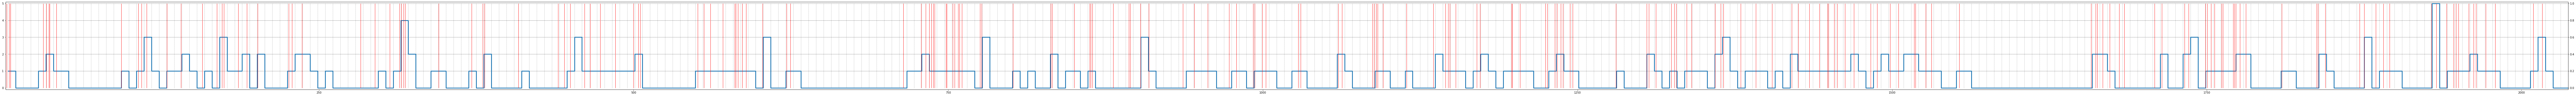

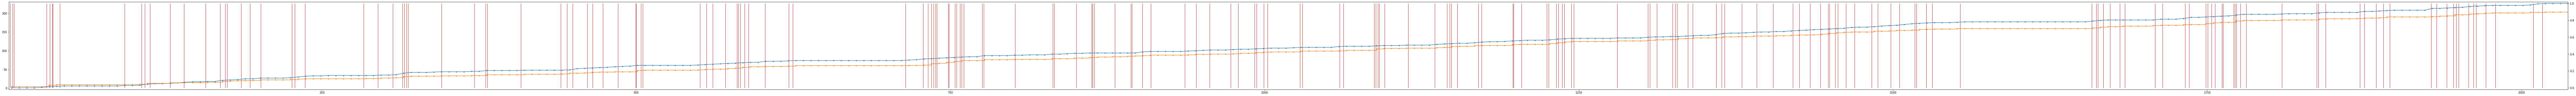

In [27]:
plot_nn_outputs(time, events, results)
plot_nn_cumsum_2(time, events, results)

[2778 1564  521  115   22]


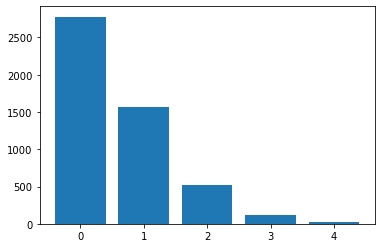

In [32]:
plot_events_density(dataset)

In [33]:
len(signal) / params.sr, TILL_TIME - FROM_TIME

(1405.6, 1405.6)

In [34]:
len(trn_signal[0]) / params.sr

1405.6

In [38]:
model, params = load_model(uuid, 'interval')

trn_dataset = VehicleDataset(files, from_time=FROM_TIME, till_time=TILL_TIME, params=params)

params = get_additional_params(params)

signal = load_audio(f'data/audio/{file}.MP4.wav')
    
trn_signal, trn_events = crop_signal_events(signal, events, params.sr, FROM_TIME, TILL_TIME)
trn_signal, trn_events = [trn_signal], [len(trn_events)]

trn_interval_error = validate_intervals(trn_signal, trn_events, model, trn_dataset.transform, params)


sampled 5000 from 20190819-Kutna Hora-L4-out-MVI_0040
144
140


In [39]:
trn_interval_error

4.0

In [40]:
results = validate(signal, model, dataset.transform, params, tqdm=tqdm, from_time=FROM_TIME, till_time=TILL_TIME, classification=True)

  0%|          | 0/234 [00:00<?, ?it/s]

In [21]:
len(results), np.cumsum(results)[-1]

(218, 126)

In [22]:
results1 = validate(signal, model, dataset.transform, params, tqdm=tqdm, classification=True)

  0%|          | 0/234 [00:00<?, ?it/s]

In [23]:
len(results1), np.cumsum(results1)[-1]

(234, 140)

[144]

In [152]:
file = '20190819-Kutna Hora-L4-out-MVI_0040'

signal = load_audio(f'data/audio/{file}.MP4.wav')
events = load_events(f'data/labels/{file}.MP4.txt')

files = [file]

In [153]:
uuid = 1632490067
FROM_TIME = 25 * 60
TILL_TIME = 34 * 60

model, params = load_model(uuid)

dataset = VehicleDataset(files, from_time=FROM_TIME, till_time=TILL_TIME, seed=0, params=params)
loader = DataLoader(dataset, batch_size=64)

params.val = get_additional_params(params, signal, events, start_time=FROM_TIME, end_time=TILL_TIME)

results, probs = validate(model, dataset, params.val, tqdm=tqdm, return_probs=True)

probs = probs.T / probs.sum(1)
probs = probs.T

sampled 5000 from 20190819-Kutna Hora-L4-out-MVI_0040


  0%|          | 0/89 [00:00<?, ?it/s]

In [ ]:
# np.round(probs, 2)

In [161]:
np.round(probs, 2);

In [162]:
probs;

In [163]:
n_preds, n_classes = probs.shape

M = n_preds * n_classes
N = n_preds

p_C = np.zeros((M, N))
p_C[:n_classes, 0] = probs[0]

for k in tqdm(range(1, n_preds)):     
    for i in range(M):
        
        inner_sum = 0
        for j in range(M):
            
            a = p_C[j, k - 1]
            b = probs[k][i - j] if j <= i < j + n_classes else 0
            
            inner_sum += a * b
        
        p_C[i, k] = inner_sum


  0%|          | 0/88 [00:00<?, ?it/s]

In [76]:
# def p_Ck_Ck1(probs, k, i, j, N):
#     if j <= i <= j + N:
#         return probs[k][i - j]
#     return 0
    
n_preds, n_classes = probs.shape

M = n_preds * n_classes
N = n_preds

p_C = np.zeros((M, N))
p_C[:n_classes, 0] = probs[0]

for k in tqdm(range(1, n_preds)):
    for i in range(M):
        
        inner_sum = []
        for j in range(M):
            
            a = p_C[j, k - 1]
#             b = p_Ck_Ck1(probs, k, i, j, n_classes - 1)
            b = probs[k][i - j] if j <= i < j + n_classes else 0
            
            a = 0 if a < 1e-8 else np.log(a)
            b = 0 if b < 1e-8 else np.log(b)
            
            if a == 0 or b == 0:
                continue
            
            inner_sum += [a + b]
        
        if len(inner_sum) == 0:
            p_C[i, k] = 0
        else:
            p_C[i, k] = np.exp(logsumexp(inner_sum))

  0%|          | 0/88 [00:00<?, ?it/s]

In [169]:
p_C.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [222]:
p_C.shape

(890, 89)

In [36]:
# p_C = p_C / p_C.sum(0)
# p_C.sum(0)

In [171]:
C = np.arange(M)
cdf = p_C.cumsum(0)
median_indices = np.abs(cdf - 0.5).argmin(0)
medians = C[median_indices]
medians

array([ 2,  2,  4,  6,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 14, 17, 17, 19, 19, 19, 19,
       20, 22, 22, 22, 25, 27, 28, 30, 33, 37, 37, 40, 42, 42, 42, 42, 42,
       43, 43, 43, 43, 43, 45, 47, 47, 47, 47, 48, 50, 51, 51, 53, 54, 54,
       54, 54, 54, 57, 58, 59, 61, 62, 64, 65, 66, 66, 66, 66, 66, 66, 66,
       68, 69, 70, 70])

In [172]:
np.cumsum(np.argmax(probs, axis=1))

array([ 2,  2,  4,  6,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 14, 16, 16, 18, 18, 18, 18,
       18, 20, 20, 20, 23, 25, 25, 27, 28, 32, 32, 34, 36, 36, 36, 36, 36,
       37, 37, 37, 37, 37, 39, 41, 41, 41, 41, 42, 44, 44, 44, 46, 46, 46,
       46, 46, 46, 50, 50, 52, 53, 54, 56, 58, 58, 58, 58, 58, 58, 58, 58,
       59, 61, 61, 61])

In [173]:
np.argmax(p_C, axis=0)

array([ 2,  2,  4,  6,  8,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 14, 17, 17, 19, 19, 19, 19,
       20, 22, 22, 22, 25, 27, 28, 30, 33, 37, 37, 40, 42, 42, 42, 42, 42,
       43, 43, 43, 43, 43, 45, 47, 47, 47, 47, 48, 50, 51, 51, 53, 54, 54,
       54, 54, 54, 57, 58, 59, 61, 62, 64, 65, 66, 66, 66, 66, 66, 66, 66,
       68, 70, 70, 70])

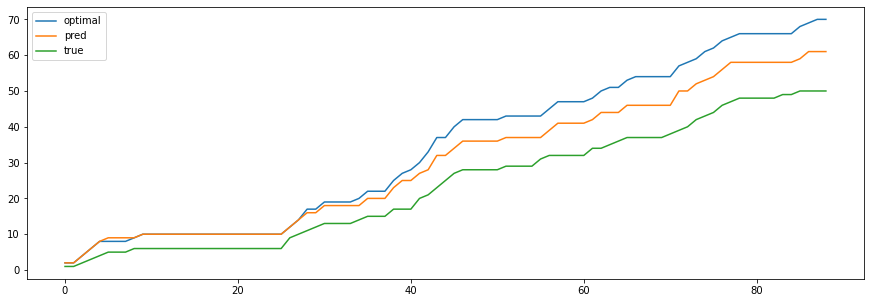

In [174]:
cumstep = get_cumstep(params.val.time, params.val.events)

preds_cumsum = np.cumsum(np.argmax(probs, axis=1))

plt.figure(figsize=(15, 5))
plt.plot(medians, label='optimal')
plt.plot(preds_cumsum, label='pred')
plt.plot(cumstep, label='true')
plt.legend();

In [41]:
print(f'pred:    {np.abs(preds_cumsum - cumstep).mean():.3f}')
print(f'optimal: {np.abs(medians - cumstep).mean():.3f}')

pred:    0.831
optimal: 1.146


In [95]:
# plt.plot(p_C[:, 20]);
# plt.plot(p_C[:, 40]);
# plt.plot(p_C[:, 60]);
# plt.plot(p_C[:, 80]);

In [266]:
np.save('Px.npy', probs.T)
Px = np.load('Px.npy')

In [270]:
Px

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [231]:
def cum_sum_distr(Px):
    max_num_events, num_windows = Px.shape
    max_num_events -= 1
    
    max_sum_events = Px.shape[0] - 1
    num_windows = Px.shape[1]


    nC = max_num_events * num_windows + 1

#    Pc = np.zeros( [nC,num_windows] )

    minus_inf = np.NINF
    log_Pc = np.empty([nC, num_windows])
    log_Pc[:] = minus_inf
    
    log_Px = np.log(Px)


    for i in range(max_num_events + 1):
#        Pc[i,0] = Px[i,0]
        log_Pc[i,0] = np.log(Px[i, 0])

    for j in range(1, num_windows):
        for c in range(nC):
            for x in range(min(max_num_events, c) + 1):
                c_prev = c-x

                tmp = []

#                if Pc[c_prev,j-1]>0 and Px[x,j]>0:
#                    Pc[c,j] = Pc[c,j] + Pc[c_prev,j-1]*Px[x,j]
#                    tmp.append( np.log(Pc[c_prev,j-1])+np.log(Px[x,j]))

                if log_Pc[c_prev, j - 1] > minus_inf and log_Px[x, j] > minus_inf:
                    tmp.append(log_Pc[c_prev, j - 1] + log_Px[x, j])
                    
                    
                if len(tmp) > 0:
                    log_Pc[c, j] = logsumexp(np.array(tmp))

    Pc = np.exp(log_Pc)
    Pc = Pc / Pc.sum(axis=0)
                    
    return Pc
        
# np.set_printoptions(precision=5, suppress=True)

# Pc = cum_sum_distr( Px )

# print(Px)
# print(Pc)

# print( np.cumsum(np.argmax(Px,axis=0)))
# print( np.argmin(np.abs(np.cumsum(Pc,axis=0 ) -0.5 ),axis=0))


In [248]:
probs.T.shape

(10, 89)

In [244]:
Pc = cum_sum_distr(probs.T)

In [225]:
# C = np.arange(M)
# cdf = Pc.cumsum(0)
# median_indices = np.abs(cdf - 0.5).argmin(0)
# medians = C[median_indices]

In [249]:
Pc.shape

(802, 89)

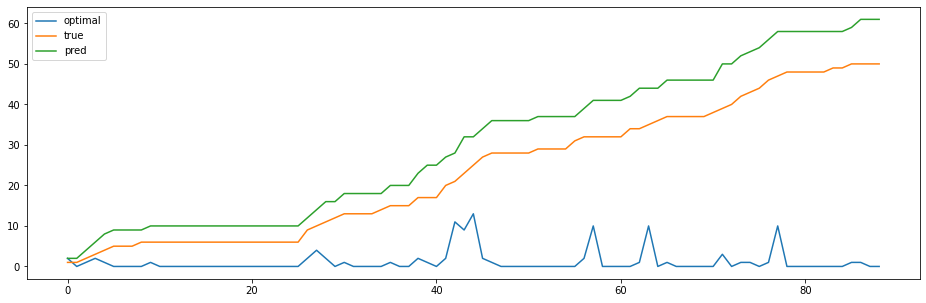

In [250]:
cumstep = get_cumstep(params.val.time, params.val.events)
median = np.argmin(np.abs(np.cumsum(Pc, axis=0) - 0.5), axis=0)
preds_cumsum = np.cumsum(np.argmax(probs, axis=1))

plt.figure(figsize=(16, 5))
plt.plot(median, label='optimal')
plt.plot(cumstep, label='true')
plt.plot(preds_cumsum, label='pred')
plt.legend();

In [186]:
from tests.seqevents import Events

In [5]:
signal = load_audio('data/audio/20190819-Kutna Hora-L4-out-MVI_0040.MP4.wav')
events = load_events('data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt')

In [6]:
uuid = 1631563356
FROM_TIME = 25 * 60
TILL_TIME = 34 * 60

model, params = load_model(uuid)

# change hop length
params.nn_hop_length = params.nn_hop_length / 2


dataset = VehicleDataset(signal, events, start_time=FROM_TIME, end_time=TILL_TIME, seed=0, params=params)
loader = DataLoader(dataset, batch_size=64)

params.val = get_additional_params(params, signal, events, start_time=FROM_TIME, end_time=TILL_TIME)

results, probs = validate(model, dataset, params.val, tqdm=tqdm, return_probs=True)

probs = probs.T / probs.sum(1)

  0%|          | 0/178 [00:00<?, ?it/s]

/home/yermaand/miniconda3/envs/dev/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [172]:
probs.shape

(10, 178)

In [7]:
n_classes, n_preds = probs.shape

A = Events(5, n_preds)

In [174]:
# Pc = A.conv(probs)

In [8]:
print(probs.shape)
Pc = np.concatenate((probs, np.zeros([1, n_preds])), axis=0)
print(Pc.shape)

(10, 178)
(11, 178)


In [9]:
est_Px, est_Pc, kl_hist = A.deconv(Pc)

In [10]:
est_Px.shape

(6, 178)

In [11]:
est_Px.argmax(0).cumsum()

array([ 0,  1,  1,  1,  1,  2,  3,  3,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  7,  7,  7,  9, 10, 11, 11, 11, 12, 13, 13, 13, 13, 13, 13, 13,
       14, 15, 15, 16, 16, 16, 16, 16, 17, 17, 18, 18, 18, 18, 18, 20, 20,
       22, 22, 24, 24, 24, 25, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 28, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 35, 35, 36, 36, 37, 37, 37, 39, 39, 39, 40,
       40, 41, 41, 41, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 44,
       44, 44, 45, 45, 45, 45, 45, 45])

In [12]:
preds_cumsum = np.cumsum(np.argmax(probs, axis=0))

In [13]:
preds_cumsum.shape

(178,)

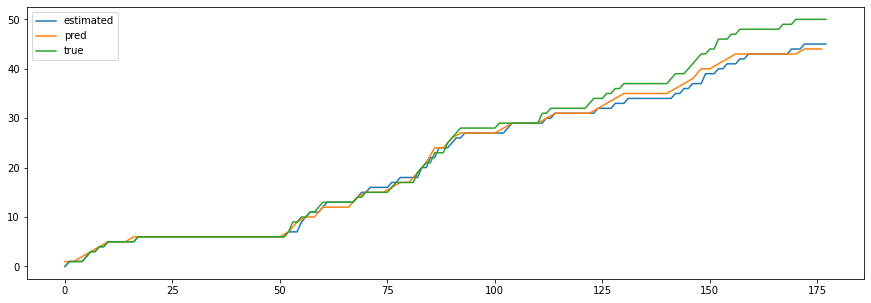

In [16]:
cumstep = get_cumstep(params.val.time, params.val.events)

preds_cumsum = np.cumsum(np.argmax(probs, axis=0)[::2])

estimated = est_Px.argmax(0).cumsum()

plt.figure(figsize=(15, 5))
plt.plot(estimated, label='estimated')
plt.plot(np.arange(0, len(cumstep), 2), preds_cumsum, label='pred')
# plt.plot(preds_cumsum, label='pred')
plt.plot(cumstep, label='true')
plt.legend();

In [17]:
print(f'pred: {np.abs(preds_cumsum - cumstep[::2]).mean():.3f}')
print(f'estm: {np.abs(estimated - cumstep).mean():.4f}')

pred: 1.404
estm: 1.6742


In [96]:
FROM_TIME = 0 * 60
TILL_TIME = 34 * 60

files = [
#     '20190819-Kutna Hora-L4-out-MVI_0040',
    '20190819-Kutna Hora-L2-in-MVI_0030'
]


intervals, events_in_intervals = get_intervals_from_files(files, FROM_TIME, TILL_TIME)

loading: 20190819-Kutna Hora-L2-in-MVI_0030


In [97]:
uuid = 1633008514
suffix = 'mae'

model = model, params = load_model(uuid, suffix)

trn_interval_error = validate_intervals(intervals, events_in_intervals, model, dataset.transform, params)

In [98]:

trn_interval_error * len(intervals)

77.00000000000001

In [100]:
signal = torch.cat(intervals)
results = validate(signal, model, dataset.transform, params, tqdm=tqdm)

  0%|          | 0/328 [00:00<?, ?it/s]

In [101]:
np.cumsum(results)[-1] - events_in_intervals.sum()

72.0

In [103]:
events_in_intervals.sum()

244.0